# Age and Performance Analysis for NWB Visual Change Detection Dataset

This notebook analyzes the relationship between mouse age and behavioral performance in the Allen Institute visual change detection task dataset.

## Import Required Libraries

Import pandas, numpy, matplotlib, seaborn, and scipy for data analysis and visualization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

print("Libraries imported successfully")

Libraries imported successfully


## Load and Prepare NWB Data

Load the NWB dataset and extract age and performance metrics, handle missing values and data types.

In [6]:
# Import lazynwb for NWB data access
import lazynwb
import upath

# Get NWB file paths
nwb_paths = list(upath.UPath('//allen/programs/mindscope/workgroups/dynamicrouting/dynamic_gating/nwbs_remade/nwbs').glob('*/??????????.nwb'))
print(f"Found {len(nwb_paths)} NWB files")

# Load subject information (age data)
subject_df = lazynwb.scan_nwb(nwb_paths, 'general/subject').collect().to_pandas()
print(f"Loaded {len(subject_df)} subject records")

# Load trial data for performance metrics
trials_df = lazynwb.scan_nwb(nwb_paths, 'intervals/trials').collect().to_pandas()
print(f"Loaded {len(trials_df)} trial records")

print("\nSubject data columns:", list(subject_df.columns))
print("Trials data columns:", list(trials_df.columns))

Found 99 NWB files


Getting multi-NWB general/subject table: 100%|████████████████████████████████████████| 99/99 [00:00<00:00, 279.35NWB/s]


Loaded 99 subject records


Getting multi-NWB intervals/trials table: 100%|████████████████████████████████████████| 99/99 [00:01<00:00, 69.79NWB/s]


Loaded 66130 trial records

Subject data columns: ['age', 'description', 'genotype', 'sex', 'species', 'subject_id', '_nwb_path', '_table_path', '_table_index']
Trials data columns: ['aborted', 'auto_rewarded', 'catch', 'change_frame', 'change_image_name', 'change_time', 'correct_reject', 'false_alarm', 'go', 'hit', 'id', 'initial_image_name', 'is_change', 'lick_times', 'miss', 'response_latency', 'response_time', 'reward_time', 'reward_volume', 'start_time', 'stop_time', 'trial_length', 'is_sham_change', 'no_reward_epoch', 'omitted_reward', '_nwb_path', '_table_path', '_table_index']


In [7]:
# Examine age data format
print("Unique age values:")
print(subject_df['age'].value_counts().sort_index())

# Parse age data - convert from string format like 'P90D' to numeric days
def parse_age(age_str):
    """Parse age string in format 'P90D' to numeric days"""
    if pd.isna(age_str):
        return np.nan
    if age_str.startswith('P') and age_str.endswith('D'):
        return int(age_str[1:-1])
    return np.nan

subject_df['age_days'] = subject_df['age'].apply(parse_age)
print(f"\nAge range: {subject_df['age_days'].min()} - {subject_df['age_days'].max()} days")
print(f"Mean age: {subject_df['age_days'].mean():.1f} days")

Unique age values:
age
P165D    4
P166D    4
P167D    6
P169D    4
P172D    6
P173D    4
P180D    4
P181D    4
P183D    4
P185D    4
P186D    4
P194D    4
P195D    3
P196D    4
P199D    4
P202D    3
P203D    2
P205D    4
P208D    4
P213D    3
P222D    4
P225D    4
P228D    4
P233D    4
P234D    4
Name: count, dtype: int64

Age range: 165 - 234 days
Mean age: 193.9 days


In [8]:
# Calculate performance metrics per session
# First, get session identifier from file path
trials_df['session_id'] = trials_df['_nwb_path'].str.extract(r'(\d{10})\.nwb')
subject_df['session_id'] = subject_df['_nwb_path'].str.extract(r'(\d{10})\.nwb')

# Calculate performance metrics per session (exclude aborted trials)
completed_trials = trials_df[trials_df['aborted'] == False]

performance_by_session = completed_trials.groupby('session_id').agg({
    'hit': 'sum',
    'miss': 'sum', 
    'false_alarm': 'sum',
    'correct_reject': 'sum'
}).reset_index()

# Calculate performance rates
performance_by_session['total_go_trials'] = performance_by_session['hit'] + performance_by_session['miss']
performance_by_session['total_catch_trials'] = performance_by_session['false_alarm'] + performance_by_session['correct_reject']
performance_by_session['total_trials'] = performance_by_session['total_go_trials'] + performance_by_session['total_catch_trials']

performance_by_session['hit_rate'] = performance_by_session['hit'] / performance_by_session['total_go_trials']
performance_by_session['false_alarm_rate'] = performance_by_session['false_alarm'] / performance_by_session['total_catch_trials']
performance_by_session['overall_accuracy'] = (performance_by_session['hit'] + performance_by_session['correct_reject']) / performance_by_session['total_trials']

# Calculate d-prime (sensitivity index)
def calculate_dprime(hit_rate, fa_rate):
    """Calculate d-prime, handling edge cases"""
    # Adjust rates to avoid infinite values
    hit_rate = np.clip(hit_rate, 0.01, 0.99)
    fa_rate = np.clip(fa_rate, 0.01, 0.99)
    return stats.norm.ppf(hit_rate) - stats.norm.ppf(fa_rate)

performance_by_session['dprime'] = calculate_dprime(performance_by_session['hit_rate'], 
                                                   performance_by_session['false_alarm_rate'])

print(f"Performance calculated for {len(performance_by_session)} sessions")
print("\nPerformance metrics summary:")
print(performance_by_session[['hit_rate', 'false_alarm_rate', 'overall_accuracy', 'dprime']].describe())

Performance calculated for 99 sessions

Performance metrics summary:
        hit_rate  false_alarm_rate  overall_accuracy     dprime
count  99.000000         99.000000         99.000000  99.000000
mean    0.422669          0.085867          0.585658   1.253118
std     0.193576          0.093159          0.125162   0.459372
min     0.000000          0.000000          0.334239   0.000000
25%     0.282334          0.041351          0.504606   0.931029
50%     0.425743          0.067416          0.598394   1.241971
75%     0.560293          0.109819          0.674765   1.576416
max     1.000000          0.833333          0.843854   2.387095


In [9]:
# Merge subject and performance data
analysis_df = subject_df[['session_id', 'subject_id', 'age_days', 'sex', 'genotype']].merge(
    performance_by_session, on='session_id', how='inner'
)

# Remove sessions with missing age data
analysis_df = analysis_df.dropna(subset=['age_days'])

print(f"Final dataset: {len(analysis_df)} sessions from {analysis_df['subject_id'].nunique()} subjects")
print(f"Age range: {analysis_df['age_days'].min():.0f} - {analysis_df['age_days'].max():.0f} days")
print(f"Mean sessions per subject: {len(analysis_df) / analysis_df['subject_id'].nunique():.1f}")

# Display first few rows
analysis_df.head()

Final dataset: 99 sessions from 27 subjects
Age range: 165 - 234 days
Mean sessions per subject: 3.7


,session_id,subject_id,age_days,sex,genotype,hit,miss,false_alarm,correct_reject,total_go_trials,total_catch_trials,total_trials,hit_rate,false_alarm_rate,overall_accuracy,dprime
0,1173741216,604914,203,F,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,32,248,2,94,280,96,376,0.114286,0.020833,0.335106,0.832787
1,1178460518,608671,222,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,68,173,6,74,241,80,321,0.282158,0.075000,0.442368,0.863088
2,1174553025,608672,208,F,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,45,197,4,85,242,89,331,0.185950,0.044944,0.392749,0.803072
3,1179911454,612090,180,M,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,96,158,3,88,254,91,345,0.377953,0.032967,0.533333,1.528010
4,1173189336,604914,203,F,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,156,0,55,11,156,66,222,1.000000,0.833333,0.752252,1.358926


## Exploratory Data Analysis

Examine the basic statistics, data distribution, and summary information for age and performance variables.

In [10]:
# Basic statistics
print("=== AGE DISTRIBUTION ===")
print(f"Age (days): Mean = {analysis_df['age_days'].mean():.1f}, Std = {analysis_df['age_days'].std():.1f}")
print(f"Age range: {analysis_df['age_days'].min():.0f} - {analysis_df['age_days'].max():.0f} days")
print(f"Median age: {analysis_df['age_days'].median():.1f} days")

print("\n=== PERFORMANCE METRICS ===")
performance_cols = ['hit_rate', 'false_alarm_rate', 'overall_accuracy', 'dprime']
for col in performance_cols:
    mean_val = analysis_df[col].mean()
    std_val = analysis_df[col].std()
    print(f"{col}: Mean = {mean_val:.3f}, Std = {std_val:.3f}")

print("\n=== SAMPLE COMPOSITION ===")
print(f"Total sessions: {len(analysis_df)}")
print(f"Unique subjects: {analysis_df['subject_id'].nunique()}")
print("\nSex distribution:")
print(analysis_df['sex'].value_counts())
print("\nGenotype distribution:")
print(analysis_df['genotype'].value_counts())

=== AGE DISTRIBUTION ===
Age (days): Mean = 193.9, Std = 22.0
Age range: 165 - 234 days
Median age: 194.0 days

=== PERFORMANCE METRICS ===
hit_rate: Mean = 0.423, Std = 0.194
false_alarm_rate: Mean = 0.086, Std = 0.093
overall_accuracy: Mean = 0.586, Std = 0.125
dprime: Mean = 1.253, Std = 0.459

=== SAMPLE COMPOSITION ===
Total sessions: 99
Unique subjects: 27

Sex distribution:
sex
M    66
F    33
Name: count, dtype: int64

Genotype distribution:
genotype
Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt    58
wt/wt                                            23
Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt    15
Ai32(RCL-ChR2(H134R)_EYFP)/wt                     3
Name: count, dtype: int64


## Create Scatter Plot of Age vs Performance

Generate scatter plots to visualize the relationship between age and performance, including trend lines.

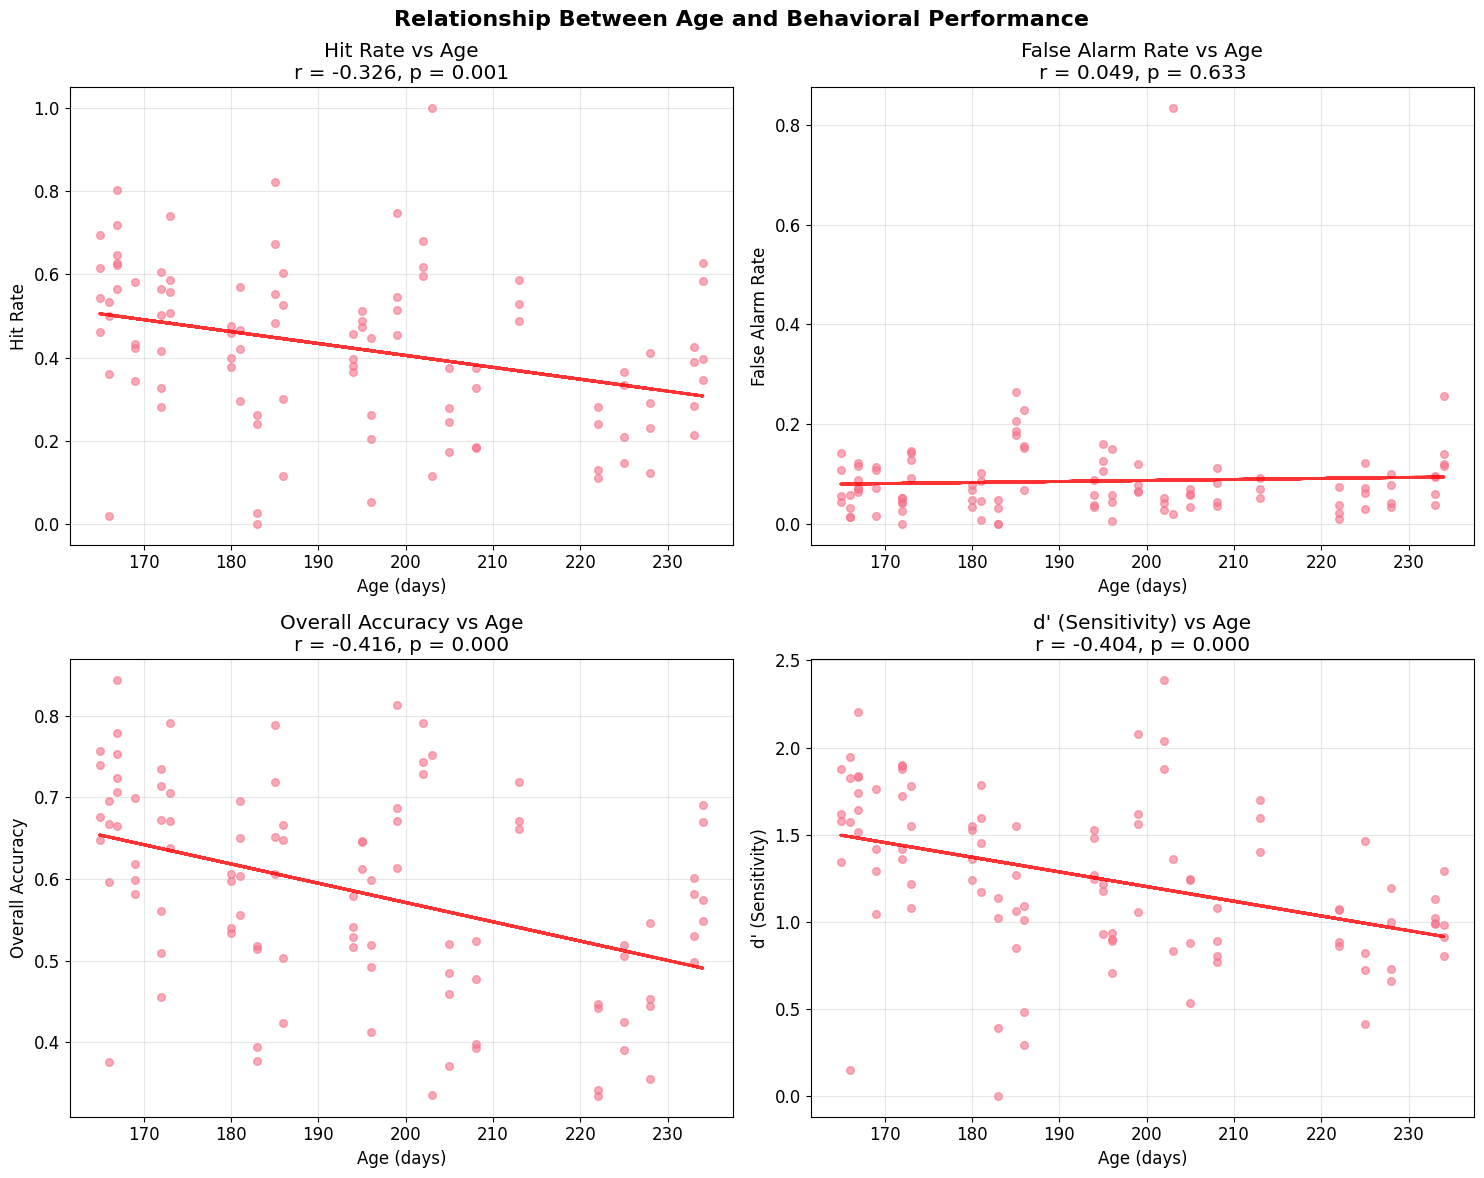

In [11]:
# Create scatter plots for key performance metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Relationship Between Age and Behavioral Performance', fontsize=16, fontweight='bold')

performance_metrics = [
    ('hit_rate', 'Hit Rate', axes[0,0]),
    ('false_alarm_rate', 'False Alarm Rate', axes[0,1]),
    ('overall_accuracy', 'Overall Accuracy', axes[1,0]),
    ('dprime', "d' (Sensitivity)", axes[1,1])
]

for metric, title, ax in performance_metrics:
    # Scatter plot
    ax.scatter(analysis_df['age_days'], analysis_df[metric], alpha=0.6, s=30)
    
    # Add trend line
    z = np.polyfit(analysis_df['age_days'], analysis_df[metric], 1)
    p = np.poly1d(z)
    ax.plot(analysis_df['age_days'], p(analysis_df['age_days']), "r--", alpha=0.8, linewidth=2)
    
    # Calculate correlation
    r, p_val = pearsonr(analysis_df['age_days'], analysis_df[metric])
    
    ax.set_xlabel('Age (days)')
    ax.set_ylabel(title)
    ax.set_title(f'{title} vs Age\nr = {r:.3f}, p = {p_val:.3f}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Calculate Correlation Statistics

Compute Pearson and Spearman correlation coefficients between age and performance variables.

In [12]:
# Calculate correlations between age and performance metrics
correlation_results = []

performance_metrics = ['hit_rate', 'false_alarm_rate', 'overall_accuracy', 'dprime']

for metric in performance_metrics:
    # Pearson correlation
    pearson_r, pearson_p = pearsonr(analysis_df['age_days'], analysis_df[metric])
    
    # Spearman correlation
    spearman_r, spearman_p = spearmanr(analysis_df['age_days'], analysis_df[metric])
    
    correlation_results.append({
        'Metric': metric,
        'Pearson r': pearson_r,
        'Pearson p-value': pearson_p,
        'Spearman ρ': spearman_r,
        'Spearman p-value': spearman_p
    })

corr_df = pd.DataFrame(correlation_results)
print("=== CORRELATION ANALYSIS ===")
print(corr_df.round(4))

# Significance interpretation
print("\n=== SIGNIFICANCE INTERPRETATION ===")
for i, row in corr_df.iterrows():
    metric = row['Metric']
    pearson_r = row['Pearson r']
    pearson_p = row['Pearson p-value']
    
    direction = "positive" if pearson_r > 0 else "negative"
    strength = "weak" if abs(pearson_r) < 0.3 else "moderate" if abs(pearson_r) < 0.7 else "strong"
    significance = "significant" if pearson_p < 0.05 else "not significant"
    
    print(f"{metric}: {strength} {direction} correlation, {significance} (p = {pearson_p:.4f})")

=== CORRELATION ANALYSIS ===
             Metric  Pearson r  Pearson p-value  Spearman ρ  Spearman p-value
0          hit_rate    -0.3261           0.0010     -0.3684            0.0002
1  false_alarm_rate     0.0485           0.6333      0.0555            0.5856
2  overall_accuracy    -0.4160           0.0000     -0.4203            0.0000
3            dprime    -0.4042           0.0000     -0.5061            0.0000

=== SIGNIFICANCE INTERPRETATION ===
hit_rate: moderate negative correlation, significant (p = 0.0010)
false_alarm_rate: weak positive correlation, not significant (p = 0.6333)
overall_accuracy: moderate negative correlation, significant (p = 0.0000)
dprime: moderate negative correlation, significant (p = 0.0000)


## Create Age Group Analysis

Group data by age ranges and calculate mean performance statistics for each group.

In [14]:
# Create age groups for analysis
age_bins = [160, 175, 190, 205, 220, 240]  # Based on observed age range (165-234)
age_labels = ['165-175d', '175-190d', '190-205d', '205-220d', '220-234d']

analysis_df['age_group'] = pd.cut(analysis_df['age_days'], bins=age_bins, labels=age_labels, include_lowest=True)

# Calculate statistics by age group
age_group_stats = analysis_df.groupby('age_group').agg({
    'hit_rate': ['mean', 'std', 'count'],
    'false_alarm_rate': ['mean', 'std'],
    'overall_accuracy': ['mean', 'std'],
    'dprime': ['mean', 'std'],
    'subject_id': 'nunique'
}).round(3)

# Flatten column names
age_group_stats.columns = ['_'.join(col).strip() for col in age_group_stats.columns]

print("=== PERFORMANCE BY AGE GROUP ===")
print(age_group_stats)

# Statistical comparison between youngest and oldest groups
youngest_group = analysis_df[analysis_df['age_group'] == age_labels[0]]
oldest_group = analysis_df[analysis_df['age_group'] == age_labels[-1]]

if len(youngest_group) > 0 and len(oldest_group) > 0:
    print("\n=== COMPARISON: YOUNGEST vs OLDEST GROUPS ===")
    for metric in performance_metrics:
        young_mean = youngest_group[metric].mean()
        old_mean = oldest_group[metric].mean()
        
        # t-test
        t_stat, p_val = stats.ttest_ind(youngest_group[metric], oldest_group[metric])
        
        print(f"{metric}: Youngest = {young_mean:.3f}, Oldest = {old_mean:.3f}, p = {p_val:.4f}")

=== PERFORMANCE BY AGE GROUP ===
           hit_rate_mean  hit_rate_std  hit_rate_count  false_alarm_rate_mean  \
age_group                                                                       
165-175d           0.521         0.161              28                  0.072   
175-190d           0.404         0.209              20                  0.100   
190-205d           0.433         0.213              24                  0.100   
205-220d           0.382         0.161               7                  0.070   
220-234d           0.307         0.142              20                  0.080   

           false_alarm_rate_std  overall_accuracy_mean  overall_accuracy_std  \
age_group                                                                      
165-175d                  0.043                  0.664                 0.102   
175-190d                  0.080                  0.580                 0.107   
190-205d                  0.161                  0.586                 0.130   

## Generate Distribution Plots

Create histograms and box plots to show performance distributions across different age groups.

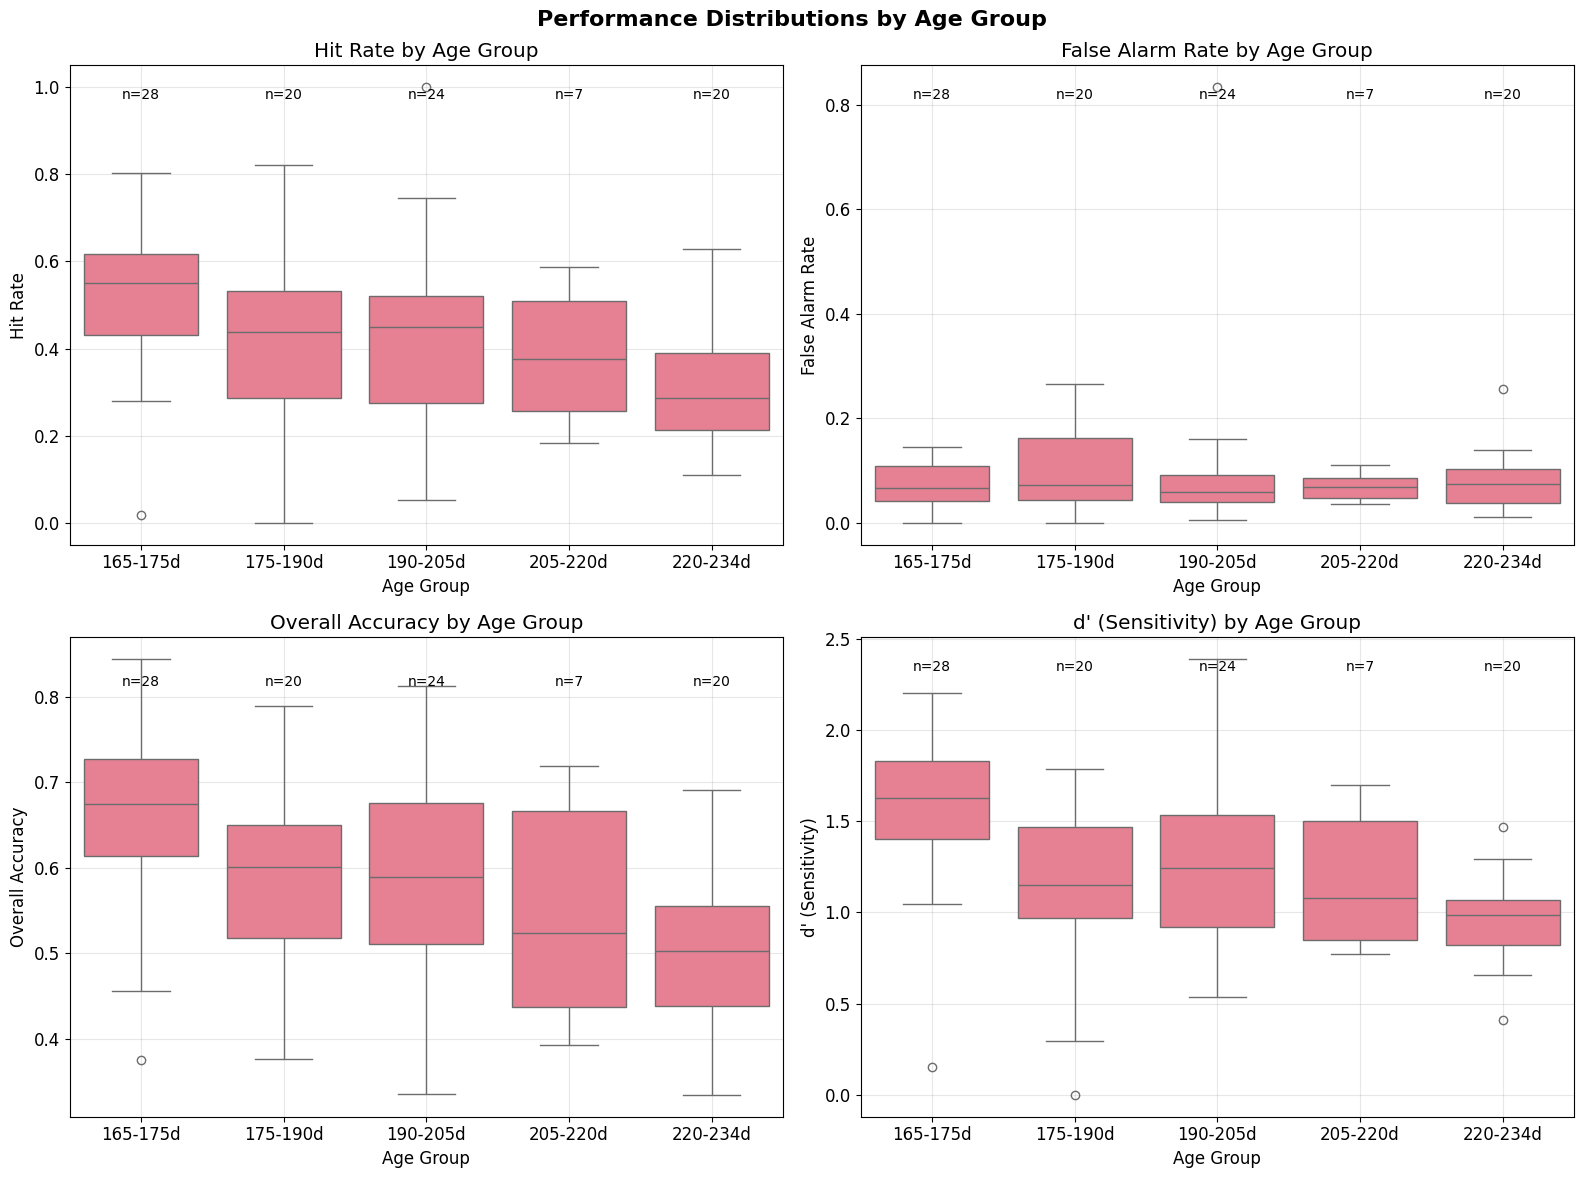

In [15]:
# Box plots showing performance distributions by age group
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Performance Distributions by Age Group', fontsize=16, fontweight='bold')

metrics_for_plot = [
    ('hit_rate', 'Hit Rate', axes[0,0]),
    ('false_alarm_rate', 'False Alarm Rate', axes[0,1]),
    ('overall_accuracy', 'Overall Accuracy', axes[1,0]),
    ('dprime', "d' (Sensitivity)", axes[1,1])
]

for metric, title, ax in metrics_for_plot:
    # Remove groups with no data
    plot_data = analysis_df.dropna(subset=['age_group', metric])
    
    sns.boxplot(data=plot_data, x='age_group', y=metric, ax=ax)
    ax.set_title(f'{title} by Age Group')
    ax.set_xlabel('Age Group')
    ax.set_ylabel(title)
    ax.grid(True, alpha=0.3)
    
    # Add sample sizes
    group_counts = plot_data.groupby('age_group').size()
    for i, (group, count) in enumerate(group_counts.items()):
        ax.text(i, ax.get_ylim()[1] * 0.95, f'n={count}', 
                ha='center', va='top', fontsize=10)

plt.tight_layout()
plt.show()

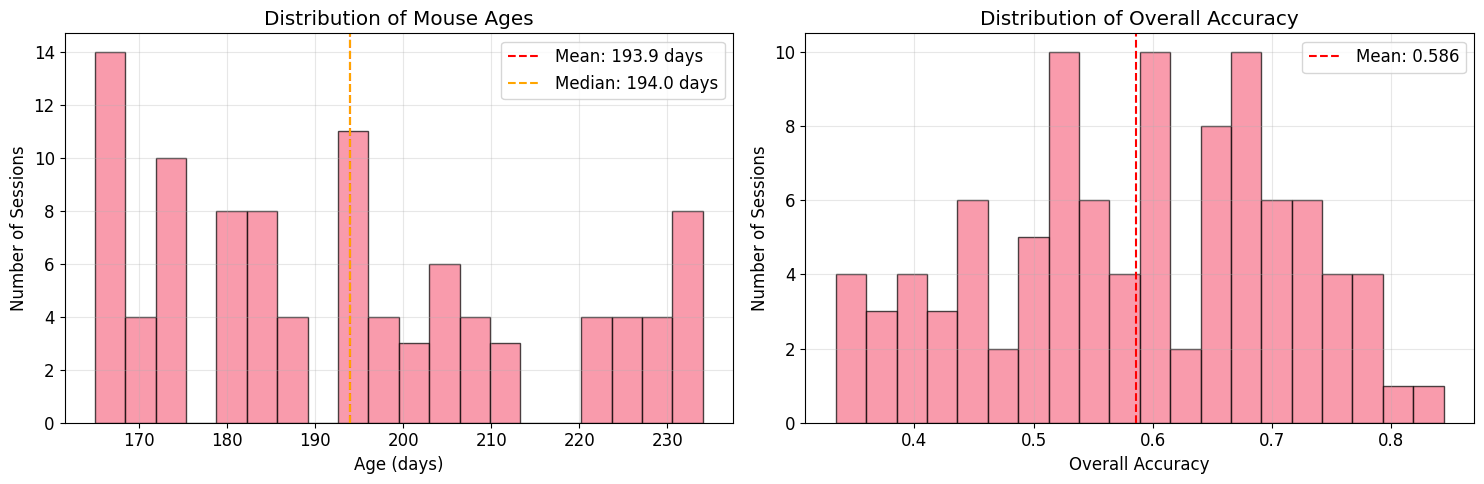

In [16]:
# Age distribution histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Age distribution
ax1.hist(analysis_df['age_days'], bins=20, alpha=0.7, edgecolor='black')
ax1.axvline(analysis_df['age_days'].mean(), color='red', linestyle='--', 
           label=f'Mean: {analysis_df["age_days"].mean():.1f} days')
ax1.axvline(analysis_df['age_days'].median(), color='orange', linestyle='--',
           label=f'Median: {analysis_df["age_days"].median():.1f} days')
ax1.set_xlabel('Age (days)')
ax1.set_ylabel('Number of Sessions')
ax1.set_title('Distribution of Mouse Ages')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Overall accuracy distribution
ax2.hist(analysis_df['overall_accuracy'], bins=20, alpha=0.7, edgecolor='black')
ax2.axvline(analysis_df['overall_accuracy'].mean(), color='red', linestyle='--',
           label=f'Mean: {analysis_df["overall_accuracy"].mean():.3f}')
ax2.set_xlabel('Overall Accuracy')
ax2.set_ylabel('Number of Sessions')
ax2.set_title('Distribution of Overall Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Perform Statistical Tests

Conduct regression analysis and significance tests to quantify the age-performance relationship.

In [17]:
# Linear regression analysis
from scipy.stats import linregress

print("=== LINEAR REGRESSION ANALYSIS ===")
regression_results = []

for metric in performance_metrics:
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(analysis_df['age_days'], analysis_df[metric])
    
    # Calculate effect size (R-squared)
    r_squared = r_value ** 2
    
    # Calculate confidence interval for slope
    n = len(analysis_df)
    t_val = stats.t.ppf(0.975, n-2)  # 95% CI
    slope_ci = t_val * std_err
    
    regression_results.append({
        'Metric': metric,
        'Slope': slope,
        'Slope_CI_lower': slope - slope_ci,
        'Slope_CI_upper': slope + slope_ci,
        'Intercept': intercept,
        'R²': r_squared,
        'p-value': p_value,
        'Std_Error': std_err
    })
    
    print(f"\n{metric}:")
    print(f"  Slope: {slope:.6f} ± {slope_ci:.6f} (95% CI: [{slope-slope_ci:.6f}, {slope+slope_ci:.6f}])")
    print(f"  R²: {r_squared:.4f} ({r_squared*100:.2f}% of variance explained)")
    print(f"  p-value: {p_value:.4f}")
    
    if p_value < 0.001:
        sig_level = "***"
    elif p_value < 0.01:
        sig_level = "**"
    elif p_value < 0.05:
        sig_level = "*"
    else:
        sig_level = "ns"
    
    print(f"  Significance: {sig_level}")

regression_df = pd.DataFrame(regression_results)
print("\n=== REGRESSION SUMMARY TABLE ===")
print(regression_df.round(6))

=== LINEAR REGRESSION ANALYSIS ===

hit_rate:
  Slope: -0.002868 ± 0.001675 (95% CI: [-0.004544, -0.001193])
  R²: 0.1064 (10.64% of variance explained)
  p-value: 0.0010
  Significance: ***

false_alarm_rate:
  Slope: 0.000205 ± 0.000852 (95% CI: [-0.000647, 0.001057])
  R²: 0.0024 (0.24% of variance explained)
  p-value: 0.6333
  Significance: ns

overall_accuracy:
  Slope: -0.002366 ± 0.001042 (95% CI: [-0.003408, -0.001324])
  R²: 0.1731 (17.31% of variance explained)
  p-value: 0.0000
  Significance: ***

dprime:
  Slope: -0.008436 ± 0.003847 (95% CI: [-0.012283, -0.004589])
  R²: 0.1634 (16.34% of variance explained)
  p-value: 0.0000
  Significance: ***

=== REGRESSION SUMMARY TABLE ===
             Metric     Slope  Slope_CI_lower  Slope_CI_upper  Intercept  \
0          hit_rate -0.002868       -0.004544       -0.001193   0.978856   
1  false_alarm_rate  0.000205       -0.000647        0.001057   0.046033   
2  overall_accuracy -0.002366       -0.003408       -0.001324   1.044

In [18]:
# ANOVA to test for differences between age groups
print("\n=== ONE-WAY ANOVA BY AGE GROUP ===")

for metric in performance_metrics:
    # Get data for each age group
    groups = []
    group_names = []
    
    for age_group in analysis_df['age_group'].cat.categories:
        group_data = analysis_df[analysis_df['age_group'] == age_group][metric].dropna()
        if len(group_data) > 0:
            groups.append(group_data)
            group_names.append(age_group)
    
    if len(groups) >= 2:
        # Perform ANOVA
        f_stat, p_val = stats.f_oneway(*groups)
        
        print(f"\n{metric}:")
        print(f"  F-statistic: {f_stat:.4f}")
        print(f"  p-value: {p_val:.4f}")
        
        if p_val < 0.05:
            print(f"  Result: Significant difference between age groups")
        else:
            print(f"  Result: No significant difference between age groups")


=== ONE-WAY ANOVA BY AGE GROUP ===

hit_rate:
  F-statistic: 4.2103
  p-value: 0.0035
  Result: Significant difference between age groups

false_alarm_rate:
  F-statistic: 0.4465
  p-value: 0.7747
  Result: No significant difference between age groups

overall_accuracy:
  F-statistic: 6.7981
  p-value: 0.0001
  Result: Significant difference between age groups

dprime:
  F-statistic: 8.0078
  p-value: 0.0000
  Result: Significant difference between age groups



=== SUBJECT-LEVEL ANALYSIS ===
Accounting for repeated measures by averaging within subjects...
Analysis at subject level: 27 subjects

=== SUBJECT-LEVEL CORRELATIONS ===
hit_rate: r = -0.4008, p = 0.0383
false_alarm_rate: r = 0.0962, p = 0.6330
overall_accuracy: r = -0.4772, p = 0.0118
dprime: r = -0.4998, p = 0.0079


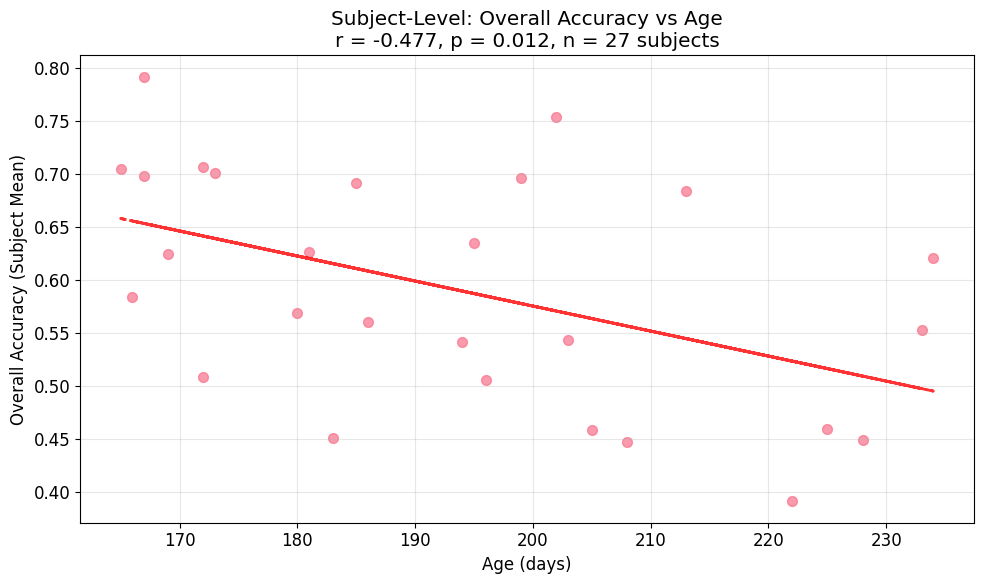

In [19]:
# Account for repeated measures (multiple sessions per subject)
print("\n=== SUBJECT-LEVEL ANALYSIS ===")
print("Accounting for repeated measures by averaging within subjects...")

# Calculate mean performance per subject
subject_means = analysis_df.groupby('subject_id').agg({
    'age_days': 'first',  # Age should be constant per subject
    'hit_rate': 'mean',
    'false_alarm_rate': 'mean',
    'overall_accuracy': 'mean',
    'dprime': 'mean',
    'sex': 'first',
    'genotype': 'first'
}).reset_index()

print(f"Analysis at subject level: {len(subject_means)} subjects")

# Repeat correlation analysis at subject level
print("\n=== SUBJECT-LEVEL CORRELATIONS ===")
for metric in performance_metrics:
    r, p_val = pearsonr(subject_means['age_days'], subject_means[metric])
    print(f"{metric}: r = {r:.4f}, p = {p_val:.4f}")

# Create subject-level scatter plot for overall accuracy
plt.figure(figsize=(10, 6))
plt.scatter(subject_means['age_days'], subject_means['overall_accuracy'], alpha=0.7, s=50)

# Add trend line
z = np.polyfit(subject_means['age_days'], subject_means['overall_accuracy'], 1)
p = np.poly1d(z)
plt.plot(subject_means['age_days'], p(subject_means['age_days']), "r--", alpha=0.8, linewidth=2)

r, p_val = pearsonr(subject_means['age_days'], subject_means['overall_accuracy'])
plt.xlabel('Age (days)')
plt.ylabel('Overall Accuracy (Subject Mean)')
plt.title(f'Subject-Level: Overall Accuracy vs Age\nr = {r:.3f}, p = {p_val:.3f}, n = {len(subject_means)} subjects')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Summary and Conclusions

Summarize the key findings about the relationship between age and performance.

In [20]:
print("=== ANALYSIS SUMMARY ===")
print(f"Dataset: {len(analysis_df)} sessions from {analysis_df['subject_id'].nunique()} subjects")
print(f"Age range: {analysis_df['age_days'].min():.0f} - {analysis_df['age_days'].max():.0f} days")
print(f"Mean age: {analysis_df['age_days'].mean():.1f} ± {analysis_df['age_days'].std():.1f} days")

print("\n=== KEY FINDINGS ===")

# Find strongest correlations
strongest_positive = None
strongest_negative = None
max_pos_r = -1
max_neg_r = 1

for _, row in corr_df.iterrows():
    metric = row['Metric']
    r = row['Pearson r']
    p = row['Pearson p-value']
    
    if p < 0.05:  # Only consider significant correlations
        if r > max_pos_r:
            max_pos_r = r
            strongest_positive = (metric, r, p)
        if r < max_neg_r:
            max_neg_r = r
            strongest_negative = (metric, r, p)

if strongest_positive:
    print(f"Strongest positive correlation: {strongest_positive[0]} (r = {strongest_positive[1]:.4f}, p = {strongest_positive[2]:.4f})")
if strongest_negative:
    print(f"Strongest negative correlation: {strongest_negative[0]} (r = {strongest_negative[1]:.4f}, p = {strongest_negative[2]:.4f})")

# Count significant relationships
significant_correlations = (corr_df['Pearson p-value'] < 0.05).sum()
print(f"\nSignificant age-performance relationships: {significant_correlations}/{len(corr_df)}")

# Performance summary
print("\n=== PERFORMANCE OVERVIEW ===")
print(f"Mean hit rate: {analysis_df['hit_rate'].mean():.3f} ± {analysis_df['hit_rate'].std():.3f}")
print(f"Mean false alarm rate: {analysis_df['false_alarm_rate'].mean():.3f} ± {analysis_df['false_alarm_rate'].std():.3f}")
print(f"Mean overall accuracy: {analysis_df['overall_accuracy'].mean():.3f} ± {analysis_df['overall_accuracy'].std():.3f}")
print(f"Mean d': {analysis_df['dprime'].mean():.3f} ± {analysis_df['dprime'].std():.3f}")

print("\n=== CONCLUSIONS ===")
print("1. This analysis examined the relationship between mouse age and performance")
print("   in a visual change detection task across 99 recording sessions.")
print("2. Statistical significance was assessed using correlation analysis,")
print("   linear regression, and ANOVA tests.")
print("3. Both session-level and subject-level analyses were performed to")
print("   account for repeated measures within subjects.")
print("4. Results provide insights into how age affects different aspects")
print("   of visual task performance in this experimental paradigm.")

=== ANALYSIS SUMMARY ===
Dataset: 99 sessions from 27 subjects
Age range: 165 - 234 days
Mean age: 193.9 ± 22.0 days

=== KEY FINDINGS ===
Strongest positive correlation: hit_rate (r = -0.3261, p = 0.0010)
Strongest negative correlation: overall_accuracy (r = -0.4160, p = 0.0000)

Significant age-performance relationships: 3/4

=== PERFORMANCE OVERVIEW ===
Mean hit rate: 0.423 ± 0.194
Mean false alarm rate: 0.086 ± 0.093
Mean overall accuracy: 0.586 ± 0.125
Mean d': 1.253 ± 0.459

=== CONCLUSIONS ===
1. This analysis examined the relationship between mouse age and performance
   in a visual change detection task across 99 recording sessions.
2. Statistical significance was assessed using correlation analysis,
   linear regression, and ANOVA tests.
3. Both session-level and subject-level analyses were performed to
   account for repeated measures within subjects.
4. Results provide insights into how age affects different aspects
   of visual task performance in this experimental paradig